# Analyzing NYC High School Data

This project will be analyzing high schools in New York City. The key performance indicators(KPI's) are:

* **SAT scores** by school - SAT scores for each high school in New York City
School attendance - Attendance information for each school in New York City

* **Class size** - Information on class size for each school

* **AP test results** - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* **Graduation outcomes** - The percentage of students who graduated and other outcome information
* **Demographics** - Demographic information for each school
* **School survey** - Surveys of parents, teachers, and students at each school

The main objective of this project is to see the correlation beween the demographics/school survey and the SAT scores/AP test results. 

Reading, cleaning, and combining the datasets will have to be done before analyzing and visualizing the data. 

## Read in the data

In [25]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline 

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

Now to read in all of the columns that will be worked with throughout this project. They are coming from different datasets so they have to be combined. 

In [26]:
#Reading in all_survey and d75_survey datasets. 
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

#combining datasets
survey = pd.concat([all_survey, d75_survey], axis=0)
survey["DBN"] = survey["dbn"]

#The columns that will be worked with.
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [27]:
data['survey'].head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


## Add DBN columns

In [28]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


###### Adding the district borough number(DBN) columns to the datasets.  
If you look at the dataset above, you will see that the DBN is split up between different columns. The objective in the next cell is to condense the `CSD`, `BOROUGH`, AND `SCHOOL CODE` into one column called `DBN`. 

In [29]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data['class_size']['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

## Convert columns to numeric

In [30]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [31]:
class_size = data["class_size"]

# Filtering the data to high school students in Gen Ed.
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Aggregating the average class size of each DBN
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Getting the demographics of the data set for the 2011-2012 year. 
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Filtering for the demographics of students in 2006. 
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [32]:
#Columns that will be converted to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

#for loop to change each column into numeric
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [33]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [34]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [35]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [36]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [37]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


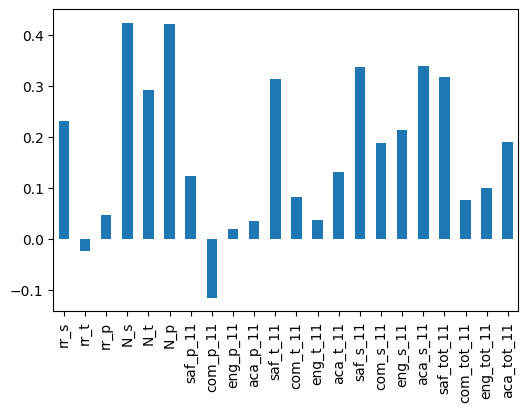

In [38]:
combined.corr()["sat_score"][survey_fields].plot.bar()

The chart depicts the N_s(Number of student respondents), the N_t, and the, N_p all having higher positive correlation with the sat scores. the saf_t_11and saf_s_11, which measure how teachers and students perceive safety at the school. 
I will be using a scatter plot to view the correlation between `saf_s_11 and` `sat_score`.

In [39]:
sat_saf_corr = combined['sat_score'].corr(combined['saf_s_11'])

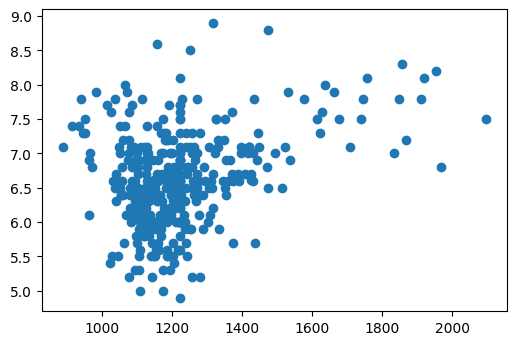

In [40]:
plt.scatter(combined['sat_score'], combined['saf_s_11'])

It looks like the correlation between the safety score and the sat score is to be expected. The lower the safety score, the lower the sat score. It makes sense that students weren't able to learn in an unstable, unsafe environment. 

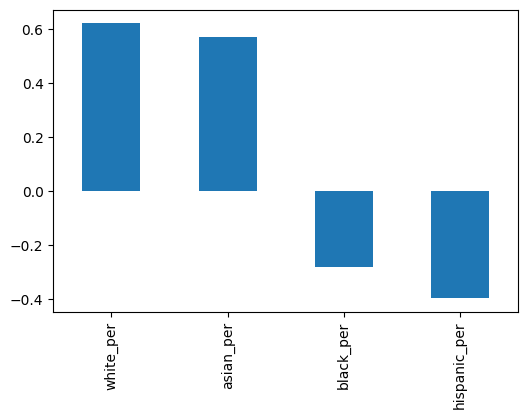

In [41]:
racial_background = ['white_per',
'asian_per',
'black_per',
'hispanic_per']

combined.corr()['sat_score'][racial_background].plot.bar()
plt.show()

The bar chart depicts the intersectional inequality of sat scores/education and racial background. Things such as income inequality can also play a big role in sat scores/education. 

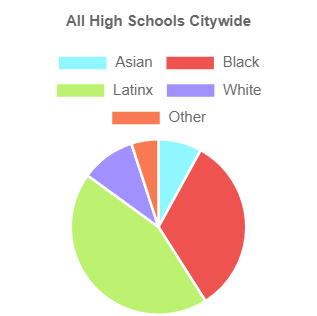

In [42]:
hispanic_per_over_95 = combined[combined['hispanic_per'] >= 95]
hispanic_per_over_95['School Name'].head(10)

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

* Many of the schools don't have a high english speaking percentage compared to other schools. 
* Many of the schools teach students both in English and Spanish. 
* Most of the schools have a substantial amount of low income students. 

- [REFERENCE#1](https://insideschools.org/school/02M542)
- [REFERENCE#2](https://insideschools.org/school/06M552)
- [REFERENCE#3](https://insideschools.org/school/10X342)



In [43]:
hispanic_per_lower_10 = combined[(combined['hispanic_per'] <= 10) & (combined['sat_score'] > 1800)]
hispanic_per_lower_10['School Name'].head(10)

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

After doing further research of the statistics of these school names, I found that:
 * Most of them don't have little to no multilingual students. 
 * All of the schools are below average in low income. 
 * All of these schools come back as majority Asian. 
 * All of these schools come back as school of the sciences. 
 * All of these schools have a very low black population as well. 


- [REFERENCE#1](https://insideschools.org/school/02M475)
- [REFERENCE#2](https://insideschools.org/school/10X445)
- [REFERENCE#3](https://insideschools.org/school/13K430)
- [REFERENCE#4](https://insideschools.org/school/28Q687)
- [REFERENCE#5](https://insideschools.org/school/31R605)

The chart below is just is of REFERENCE#1 and it depicts the status quo for all of the references above.

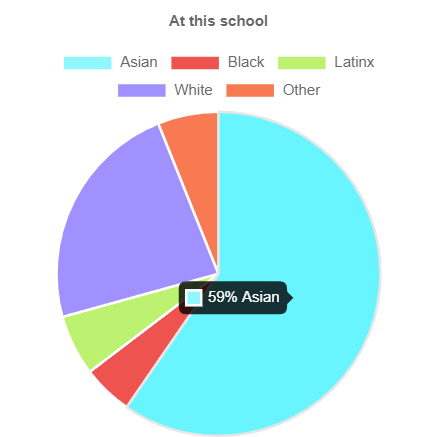

## Investigating gender differences in SAT scores

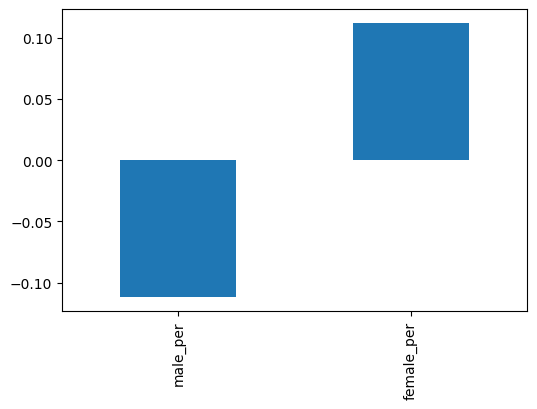

In [44]:
gender_perc = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_perc].plot.bar()
plt.show()

The bar plot illustrates that females have a positive correlation to SAT score and the males have a negative correlation to SAT score. The r value for the genders maxes out around .1 which is low. 

While this shows that theres  some correlation between gender and SAT scores, the correlation is not strong enough to be relevant.  

Next I'll investigate schools that have a high female percentage and SAT score. 

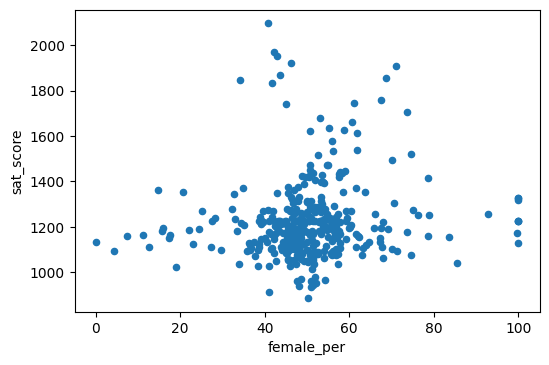

In [45]:
combined.plot.scatter(x='female_per', y='sat_score')

We see the first high SAT score when the female percentage goes above 40%. The high SAT scores continue up until the around 80%. This makes sense because there are only a few schools that have a female percentage of 80% or higher. 

In [46]:
female_perc_bool = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_perc_bool['School Name']

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object

After doing research on the schools illustrated above I came across a few intersting patterns:
* Most of the school's students are not low income.
* Most of schools have a larger white population compared to the average amount city wide.
* Most of the schools are located in the Manhattan. 
* Most of the schools have more girl sports than boy sports.
* Most of the schools do not have football as a sport. 

In [47]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

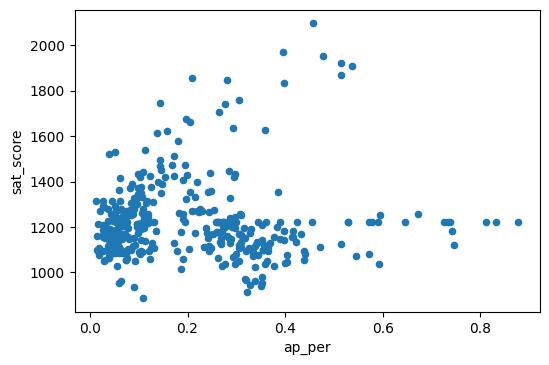

In [48]:
combined.plot.scatter('ap_per', 'sat_score')

I calculated the percentage of students in each school that took an AP exam by dividing the AP Test Takers column by the total_enrollment column. The scatter plot shows that there may be a correlation between them. 